# Applying Model to Real World
I built and trained the gender detection model in the `training.ipynb` jupyter notebook. Then the model was evaluated on the labeled test data to find accuracy over the test data. **To avoid retraining of model** everytime on restarting the kernel and save the exact weights and biases which emerged while my training I saved it as `Gender-Detection.model` in this directory. Now here in this notebook I tried to apply the model to detect gender from faces in the images of real world. In the first part I tried to predict gender of people from images, and in the secon part I tried a live detection with camera.

In [1]:
# Loading necessary libraries
import os
import cvlib as cv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

In [2]:
# Loading Model
model=load_model('gender_detection.model')

### Detection in Real Life Image
I am loading images from the folder named as `CustomImages`, where I had uploaded 20 random pictures from Google and used my model to detect the gender of people present in these images.  
If you like to use my model with your own set of images, you can simply place the pictures in that folder and run all the cells till the next cell. The model will automatically process your images and display the gender detection results.  
I am using Haar Cascades, a pre-trained face detection algorithm to detect faces in the images, then using my trained model to predict the the gender. The output contains color coded boxes(Green for Males and Blue for Females) around the faces detected with their genders written over the box along with the percentage probability the model thinks of them to be.

Processing Complete

The blue box correspond to Female gender and green box corresponds to gender being Male.


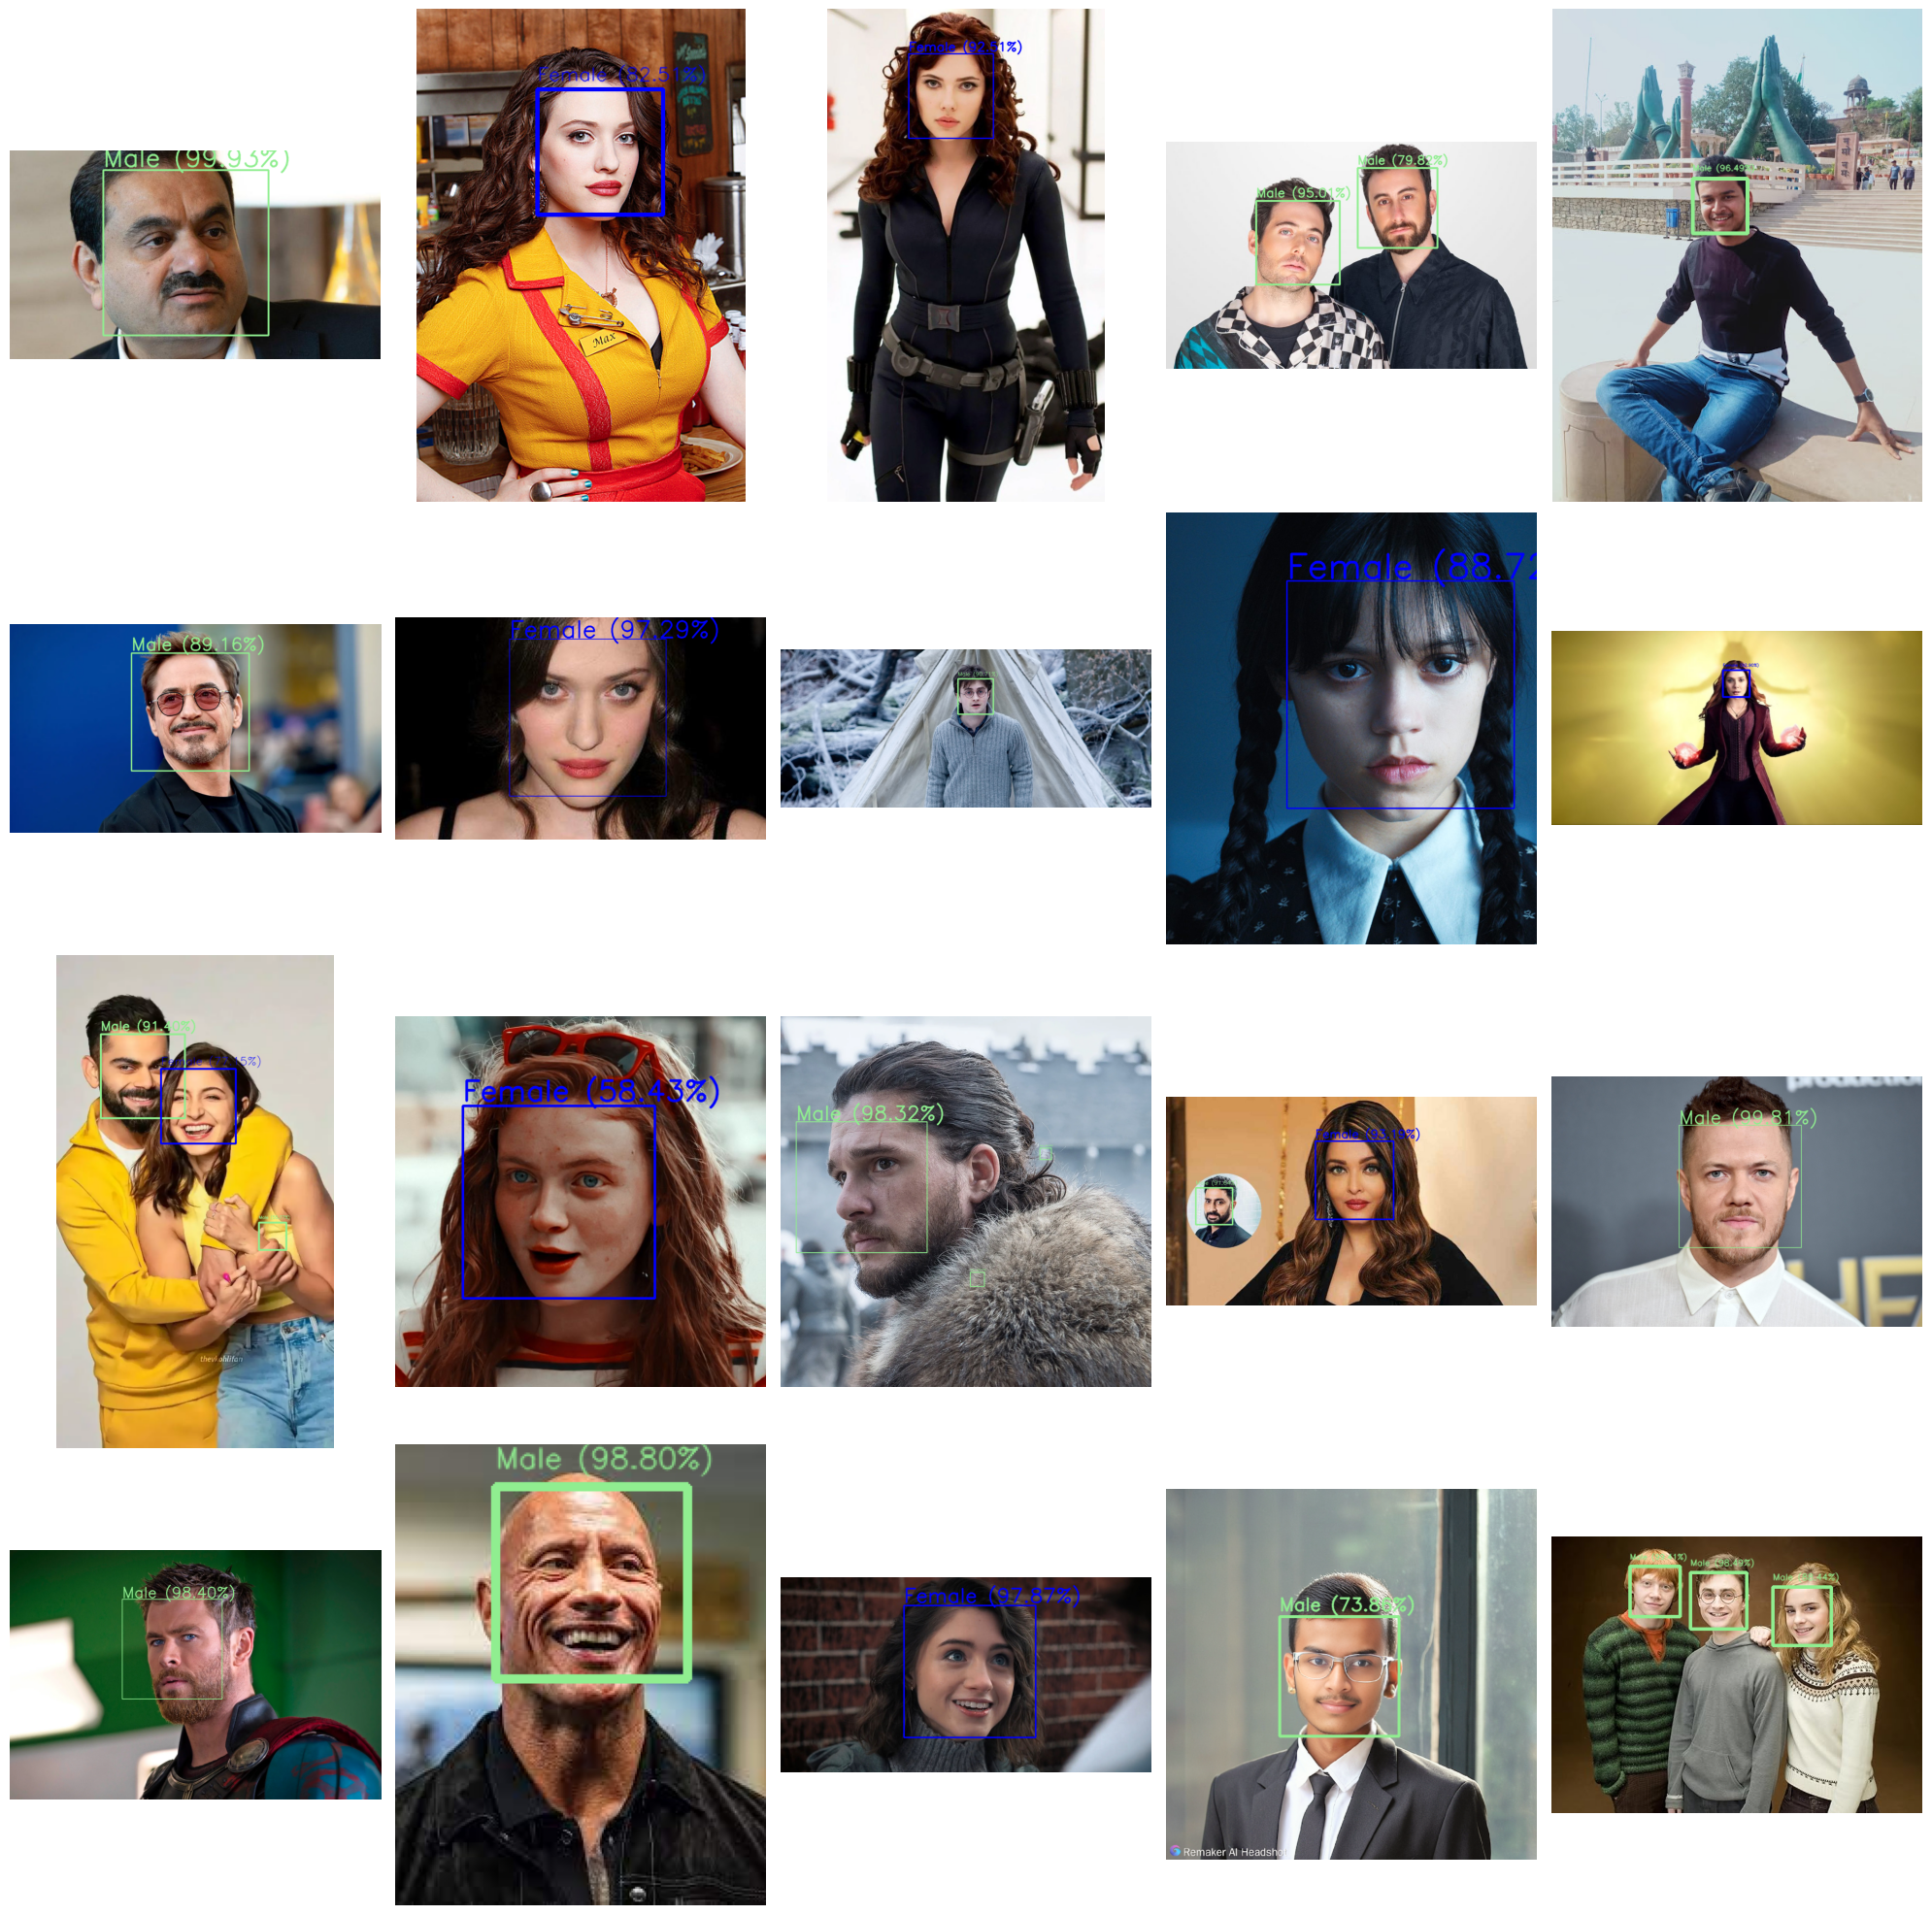

In [3]:
input_folder = "CustomImages"

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Function to preprocess images for prediction
def preprocess_image(face):
    face = cv2.resize(face, (100, 100))  # Resizing to the input size of my model
    face = face / 255.0  # Normalizing to [0, 1]
    face = np.expand_dims(face, axis=0)  # Adding batch dimension to make it a 4D matrix(the expected input shape by the model)
    return face

# List to store processed images for displaying. Although I could have displayed them directly, but I wanted them to be presented as multiple images per-row with the help of Matplot-Lib sub-plots.
processed_images = []

i=1
# Loop for processing each image in the folder
for filename in os.listdir(input_folder):
    img_path = os.path.join(input_folder, filename)
    # Accepting only valid formats to avoid any error if there's some other file
    if not img_path.lower().endswith((".jpg", ".png", ".jpeg")):
        continue
    print(f'Processing Image {i}',end='\r')

    # Reading and preprocessing the image
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale for face detection since Haar Casacade works better on greyscale.

    # Detecting faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

    # Now looping for every face in the image
    for (x, y, w, h) in faces:

        # Croping and preprocessing the face
        face = img[y:y+h, x:x+w]
        preprocessed_face = preprocess_image(face)

        # Predicting the gender
        prediction = model.predict(preprocessed_face,verbose=0)
        probability = prediction[0][0]  # Sigmoid output
        gender = "Male" if probability > 0.5 else "Female"
        confidence = probability * 100 if probability > 0.5 else (1 - probability) * 100

        # Annotating the image
        label = f"{gender} ({confidence:.2f}%)"
        color = (144, 238, 144) if gender == 'Male' else (255, 0, 0)
        font_scale = w / 200.0  # Adjusting font scale based on face width
        thickness = max(1, int(w / 100))  # Adjusting thickness based on face width
        cv2.rectangle(img, (x, y), (x+w, y+h), color, 3)  # Drawing bounding box
        cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness, cv2.LINE_AA)  # Drawing label

    # Adding the processed image to the list
    processed_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Converting BGR to RGB for displaying
    if i==20:
        print("Processing Complete")
    i+=1


# Display all processed images in a grid (5 images per row)
n_images = len(processed_images)
cols = 5  # Number of images per row
rows = (n_images + cols - 1) // cols  # Calculate required number of rows

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()

for i in range(len(axes)):
    if i < n_images:
        axes[i].imshow(processed_images[i])
        axes[i].axis('off')  # Hide axis for better display
    else:
        axes[i].axis('off')  # Turn off unused subplots

print("\nThe blue box correspond to Female gender and green box corresponds to gender being Male.")
plt.tight_layout()
plt.savefig("Demo-Output-Images.png")
plt.show()

### Live Detection
Here I am using `VideoCapture` from openCV to access my webcam. Then I am using `cvlib` to constantly detect face in frames to pass it through my model for gender prediction. And as a result a Green box is built over face if expected gender is Male and Blue if Female with the predicted gender with the probability according to the model written over the box.

In [4]:
webcam = cv2.VideoCapture(0)

while webcam.isOpened():

    # Reading frame from webcam 
    status, frame = webcam.read()

    # Apply face detection
    face, confidence = cv.detect_face(frame)

    # Looping through detected faces
    for idx, f in enumerate(face):

        # get corner points of face rectangle        
        (startX, startY) = f[0], f[1]
        (endX, endY) = f[2], f[3]

        # crop the detected face region
        face_crop = np.copy(frame[startY:endY,startX:endX])

        if (face_crop.shape[0]) < 10 or (face_crop.shape[1]) < 10:
            continue

        # preprocessing for gender detection model
        face_crop = cv2.resize(face_crop, (100,100))
        face_crop = face_crop.astype("float") / 255.0
        face_crop = img_to_array(face_crop)
        face_crop = np.expand_dims(face_crop, axis=0)

        # apply gender detection on face
        prediction = model.predict(face_crop,verbose=0)
        probability = prediction[0][0]  # Sigmoid output
        gender = "Male" if probability > 0.5 else "Female"
        confidence = probability * 100 if probability > 0.5 else (1 - probability) * 100

        # Annotate the image
        label = f"{gender} ({confidence:.2f}%)"

        color = (144, 238, 144) if gender == 'Male' else (255, 0, 0)
        
        

        # draw rectangle over face
        cv2.rectangle(frame, (startX,startY), (endX,endY), color, 2)

        Y = startY - 10 if startY - 10 > 10 else startY + 10

        # write label and confidence above face rectangle
        cv2.putText(frame, label, (startX, Y),  cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, color, 2)

    # display output
    cv2.imshow("gender detection", frame)

    # press "Q" to stop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# release resources
webcam.release()
cv2.destroyAllWindows()